# 第3章 基本的な因果推論手法
## 3.1 分析の全体像と各種手法の前提
### 3.1.1 因果推論の分析全体像

![図3.2](images/chap3/image.png)

### 3.1.2分析手法の全体像

まず因果効果の推定手法を選択するうえで、前提条件の確認が必要。そのフローの概要が以下。

![図3.5](images/chap3/image-1.png)

## 3.2 回帰分析に基づく手法
### 3.2.1 回帰分析の概要

単回帰や重回帰でモデル化できる場合

### 3.2.2 構造方程式モデルの概要

- 構造方程式モデリング(Structure Equation Modeling: SEM): 方程式を用いて変数間の関係を分析する方法
- もしくは、、共分散構造分析(Covariance Structure Analysys: CSA)と呼ぶ

特徴
1. 方程式で、各変数間の関係を検証
2. 潜在変数を導入できる(数理モデルにより推定される変数)
3. バス図(変数間の因果の方向と、係数)を用いて可視化できる

### 3.2.3 構造方程式モデルの実行手順

#### Step 1 ライブラリの準備、データの確認

In [2]:
import numpy as np
import pandas as pd

# 1. 合成データの生成
# 乱数のシードを設定(再現性のため).
rng = np.random.default_rng(0)

# サンプルサイズ
N = 200

# TVCM(テレビCMの視聴者関心度[独自指標])のデータを生成
TV_CM = rng.normal(50, 10, N)

# 気温(Temperature_C、摂氏)のデータを生成。範囲は10~35℃。
Temperature_C = rng.uniform(10, 35, N)

# ノイズ(Noise)のデータを生成
Noise = rng.normal(0, 5, N)

# 炭酸飲料の売上(Soda_Sales)を生成。TV_CMとTemperature_Cの影響を強くする。
Soda_Sales = 10 + 0.5 * TV_CM + 2.0 * Temperature_C + Noise

# データフレームを作成
data = pd.DataFrame(
    {"TV_CM": TV_CM, "Temperature_C": Temperature_C, "Soda_Sales": Soda_Sales}
)

#### Step 2 DAGの確認

* 結果変数: 炭酸飲料の売上[百万円]
* 処置変数: TVCM[視聴者関心度]
* 共変量: 気温[℃]

![図3.10](images/chap3/image-2.png)

#### Step 3 識別仮定の確認

モデル式を記述する
オペレーターは
* ~: 構造法定式(回帰)
* =~: 測定方程式(潜在変数の設定)
* ~~: 共変関係(双方向)

In [3]:
# SEMモデルの定義
model_desc = """
# 回帰分析
Soda_Sales ~ TV_CM + Temperature_C
"""

#### Step 4 因果効果の推定

因果効果の推定のために、モデルを仮定する。線形重回帰モデルでは以下の仮定を満たす必要がある。

* 線形性: 散布図や成分プラス残差プロットを用いて線形性を確認する
* 誤差項の等分散性: すべての変数において誤差(残差)の分散は一定であること。残差プロットやブルーシュ・ペイガン検定などを用いて等分散性を確認する 
* 誤差項の条件付き独立性: ある観測値の誤差が、他の観測値の誤差に影響を与えていないこと。多くの変数をモデルに含むことで、必要な共変量を可能な限り取り込む(多重共線性に注意)
* 完全な多重共線性の欠如: 多重共線性とは説明変数間に強い相関があること。FIV(Variance Inflation Factor)で多重共線性を確認する
* 正規性: 誤差項が正規分布に従うこと。残差のヒストグラム、ジャックベラの正規性検定等を用いて確認する

次にモデル構築を行う。
semopyのModelにdataを渡して、fitする。今回はfitの引数はデフォルトのまま
* 目的関数(obj): MLW(Wishart Maximum Likelihood)
* ソルバー(solver): SLSQP

In [4]:
import semopy as sem

mod = sem.Model(model_desc)
res = mod.fit(data)
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.000
Number of iterations: 27
Params: 0.538 2.026 24.556


#### Step 5 結果の評価

1. 推定検証
    * 全体的評価
        * GFI (Goodness of Fit Index): 1に近いほどモデルがデータに適合している。0.9以上が良いモデルとされる
        * RMSEA (Root Mean Square Error of Approximation) 二乗平均平方根誤差: 0に近いほど適合している。0.05以下であれば良い、0.1以上だと悪い
    * 部分的評価
        * 標準誤差
        * p値
        * z値: = 推定値 / 標準誤差

In [5]:
stats = sem.calc_stats(mod)
print(stats.T)

                      Value
DoF            3.000000e+00
DoF Baseline   5.000000e+00
chi2           4.865836e-05
chi2 p-value   9.999999e-01
chi2 Baseline  4.862756e+02
CFI            1.006233e+00
GFI            9.999999e-01
AGFI           9.999998e-01
NFI            9.999999e-01
TLI            1.010389e+00
RMSEA          0.000000e+00
AIC            6.000000e+00
BIC            1.589495e+01
LogLik         2.432918e-07


2. 推定結果の確認
    * Estimate: 推定した係数。平均処置効果(ATE)を表している
    * z-value: z値(= Estimate / Std.Err)
    * TVCMの視聴者関心度が1増加すると、炭酸飲料の売り上げが0.54[百万円]増加する
    * 気温が1℃上昇すると、売上が2[百万円]増加する
    * p値が0なので、有意であると言える

In [6]:
# モデルパラメータの確認
ins = mod.inspect()
print(ins)

         lval  op           rval   Estimate  Std. Err    z-value  p-value
0  Soda_Sales   ~          TV_CM   0.537524  0.036542  14.709568      0.0
1  Soda_Sales   ~  Temperature_C   2.026096  0.048390  41.870027      0.0
2  Soda_Sales  ~~     Soda_Sales  24.556273  2.455627  10.000000      0.0


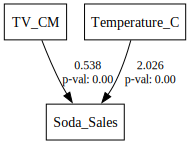

In [7]:
# SEMの可視化
sem.semplot(mod, "business_case_SEM.png")

semopyの他に、sembaというベイズモデリングにも対応可能なライブラリがある

### 3.2.4 構造方程式のモデルの課題

1. 多重共線性があるデータや非線形データへの対応が難しい(線形回帰モデル)
2. 共変量が多い場合、正値性の確認が難しくなる
3. 未観測の交絡因子が存在する場合、条件付き独立性を満たさないので、適切な推定ができない

## 3.3 共変量調整・傾向スコア

### 3.3.1 共変量調整の基礎

線形回帰が上記の問題で適用できないときの別のアプローチとして、共変量を調整する方法がある。共変量を調整して、RCTを行った結果に近づけるといったイメージ。

* 条件付き独立性と条件付き正値性に該当する「強く無視できる割当条件 (strongly ignorable treatment assignment)」を確認する
* 共変量と言っても、交絡因子を調整できればいい。調整の対象として交絡因子Cを扱う

$$
\left\{Y(1),Y(0)\right\}\perp T\left|C\right. \\
0<P\left(T=1|C\right)<1
$$

これらの式はCで条件付けをした場合に、擬似的にRCTに近い状況を表す。([節2.5参照](chap2.ipynb#25-因果推論の基礎))。バランシングスコアという関数を用いて、交絡因子を調整する。バランシングスコアの一つは傾向スコア。

### 3.3.2 傾向スコアの概要

傾向スコアの定義式。交絡因子Cで条件付けた処置確率(処置群に属する確率)。未観測の交絡因子が存在しないという前提。

$$
0 < \pi(C) < 1 \\
\pi(C) = P(T=1|C)
$$

このとき傾向スコアは、Tを目的関数とした回帰モデルを用いて計算される。傾向スコアを使うと交絡因子を1次元の指標に変換できる。

傾向スコアの活用方法の一例として、傾向スコアが近いチョチ群と対照群を比較する方法がある。

特徴

* 共変量(特に交絡因子)のバランス調整
* 正値性を満たすことを確認可能: 逗子などの確認が比較的容易

### 傾向スコア分析の実行手順

本来は交絡因子のみを調整すれば十分だが、実務ではその共変量が確実に交絡因子であるかの判断は難しいので、傾向スコアを算出する対象を広く取る。

* 問: 禁煙が体重にどの程度影響を与えるか

NHEFS(National health and Examination Follow-up Study)データセットを用いる

#### Step 1 ライブラリの準備、データの確認

causallibをインストールしておく

データの中身

![表3.3](images/chap3/image-3.png)

In [8]:
from causallib.datasets import load_nhefs

# データセットの読み込み
data = load_nhefs()
print("X\n", data.X)
print("a\n", data.a)
print("y\n", data.y)

X
       age  race  sex  smokeintensity  smokeyrs   wt71  active_1  active_2  \
0      42     1    0              30        29  79.04     False     False   
1      36     0    0              20        24  58.63     False     False   
2      56     1    1              20        26  56.81     False     False   
3      68     1    0               3        53  59.42      True     False   
4      40     0    0              20        19  87.09      True     False   
...   ...   ...  ...             ...       ...    ...       ...       ...   
1623   47     0    1              20        31  84.94     False     False   
1624   45     0    0              40        29  63.05     False     False   
1625   47     0    1              20        31  57.72     False     False   
1627   68     0    0              15        46  52.39      True     False   
1628   29     0    0              30        14  90.83      True     False   

      education_2  education_3  education_4  education_5  exercise_1  \


#### Step 2 DAGの確認

* 結果関数: 体重
* 処置変数: 喫煙をしたか否か
* 共変量: 年齢、運動量

![図3.16](images/chap3/image-4.png)

#### Step 3 識別仮定の確認

1. SUTVAの確認
2. 共変量の確認
   以下を参考に、必要な変数を可能な限り共変量に含める

   1. 当該領域に関するドメイン知識
   2. 共変量と結果変数との関連に関する統計的検定(回帰係数および各種検定指標から判断)
   3. 中間変数、合流点、操作変数

   注意事項

   * 過剰調整の回避
     傾向スコアを導入すると、バランスがかえって悪くなる事があるので、傾向スコアモデルに含める変数は慎重に考える
   * 多重共線性の検討
     線形モデルの場合、多重共線性が出る場合がある。共変量同士に強い相関がある場合は、どちらか一つを選択する。傾向スコアモデルに勾配ブースティングなどの非線形モデルを使用する場合はそれほど問題にならない

#### Step 4 因果効果の推定

1. 傾向スコアの推定
   (ロジスティック)回帰モデル、機械学習モデル(例えば勾配ブースティングなど)
2. 傾向スコアの活用
   傾向スコアを活用して、マッチングや重み付けなどを行う。よりフェアな比較に近づける意味がある

    ![図3.17](images/chap3/image-5.png)

    * マッチング
        * 処置群・対照群の共変量の値が近いもの同士を組み合わせる
        * 共変量が多いと適切なペア作るのが難しい
        * 共変量の分布の重なりがない部分は正地性の条件を満たさない
        * 1次元の傾向スコアを用いる

In [9]:
from causallib.estimation import PropensityMatching
from sklearn.linear_model import LogisticRegression

# 傾向スコアを算出するモデル(ロジスティック回帰)の定義
learner = LogisticRegression(
    solver="liblinear",  # liblinear: 線形モデル向けの最適化アルゴリズム
    class_weight="balanced",  # 正例と負例のバランスを取るために使用(第4章で説明)
)

# 傾向スコアの算出とマッチング
pm = PropensityMatching(learner=learner)
pm.fit(data.X, data.a, data.y)

PropensityMatching(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.5/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, caliper=None, covariance_conditioner=EmpiricalCovariance(), estimate_observed_outcome=False, knn_backend=sklearn, matching_mode=both, metric=mahalanobis, n_neighbors=1, propensity_transform=PropensityTransformer(learner=LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')), with_replacement=True,
                   learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [10]:
# ATEの計算
outcomes = pm.estimate_population_outcome(
    data.X,
    data.a,
)  # 処置群と対照群それぞれの結果変数の平均値を推定
effect = pm.estimate_effect(outcomes[1], outcomes[0])  # ATEを推定

# 結果の出力
# 喫煙を続けた場合の平均的な体重増加の推定値
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
# 禁煙した場合の平均的な体重増加の推定値
print(f"Average outcome of Treated: {outcomes[1]:.3f}")
# 傾向スコアマッチングによるATEの推定値
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.635
Average outcome of Treated: 5.319
Average Treatment Effect: 3.684


* 層別解析: 母集団を何らかの属性で分割して比較
* 重み付け

    * 観測データの各個体に適切な重みを割り当てて、処置群と対照群の分布が似ている疑似母集団を形成する
    * 傾向スコアを用いる
    * 逆確率重み付け(Inverse Probability Weighting: IPW)

        * 処置群には傾向スコアの逆数で重み付けする
        * 対照群には(1 - 傾向スコア)の逆数で重み付けする
        * ATEは以下の式で表される。基本的なATE$\frac{1}{n}\sum_{i=1}^{n}T_{i}Y_{i}-\frac{1}{n}\sum_{i=1}^{n}(1-T_{i})Y_{i}$に重み付けを追加した形
        $$
        \widehat{ATE}_{IPW}={\frac{1}{n}}\sum_{i=1}^{n}{\frac{T_{i}Y_{i}}{{\hat{\pi}}\left(X_{i}\right)}}-{\frac{1}{n}}\sum_{i=1}^{n}{\frac{\left(1-T_{i}\right)Y_{i}}{1-{\hat{\pi}}\left(X_{i}\right)}}
        $$
    * 二重にロバストな推定量 (Doubly Robust Estimator)
    * 共変量バランス傾向スコア
    * 処置群の個体をもとに、対照群の個体をマッチングにより選択する → 対照群の個体を0.1で重み付けすることと同じ

傾向スコアを使用したその他の方法
* メタラーナー
* ツリーモデル
* 表現学習
* マルチタスク学習法


In [11]:
from causallib.estimation import IPW
from sklearn.linear_model import LogisticRegression

# 傾向スコアを算出するモデルの定義
learner = LogisticRegression(solver="liblinear", class_weight="balanced")

# 傾向スコアを算出し、IPWを実施
ipw = IPW(learner=learner)
ipw.fit(data.X, data.a)

# ATEの計算
outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

# 結果の出力
# 喫煙を続けた場合の平均的な体重増加の推定値
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
# 禁煙した場合の平均的な体重増加の推定値
print(f"Average outcome of Treated: {outcomes[1]:.3f}")
# 傾向スコアマッチングによるATEの推定値
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.570
Average outcome of Treated: 4.975
Average Treatment Effect: 3.406


#### Step 5 結果の評価

共変量の調整結果を評価するには、一般的には各群の共変量や傾向スコアを比較

* 共変量や傾向スコアのバランスが取れている → 識別仮定の条件付き独立性、正値性を満たす
* 各群の傾向スコアの重複が少ない → フェアに比較できない → 共変量の再選択、モデルの調整が必要
  * 傾向スコアは複数の共変量をまとめてスコア化した処置される確率。厳密に言うと、観測された共変量全てで条件付けされた処置確率。
  * ここでいう重複とは、処置群と対照群で傾向スコアが同じ範囲に分布しているかどうか(共有サポート, common support)
  * [参考](http://yukiyanai.github.io/jp/classes/econometrics2/contents/slides/metrics2_topic05_slides.pdf)

評価の基準と方法

1. 絶対標準化平均差 (Absolute Standad Mean Difference: ASMD)
   共変量のバランスの評価指標

   $$
   SMD={\frac{{\bar{{X}}}_{1}-{\bar{{X}}}_{0}}{\sigma_{pool}}} \\
   \sigma_{pool}^{2}=\frac{\left(N_{1}-1\right)\sigma_{1}^{2}+\left(N_{0}-1\right)\sigma_{0}^{2}}{N_{1}+N_{2}-2}
   $$

   * $\bar{X_1}$: 処置群の共変量の平均値
   * $\bar{X_0}$: 対照群の共変量の平均値
   * $\sigma_1^2$: 処置群の共変量の分散
   * $\sigma_0^2$: 対象群の共変量の分散
   * $N_1$: 処置群の個体数
   * $N_0$: 対象群の個体数
   * $N_2$: $N_0$の誤字?

   SMDは、共変量の分布の重なり度合いを示す(SMDが小さい時、重なりが大きい)。厳密には絶対値を取った絶対標準化平均差(ABsolute Standarized Mean Difference: ASMD)を使用する。
   共変量バランスの判定には任意のカットオフ値(ASMDの場合0.1未満が推奨)を使用する。Pythonではcausalib.evaluateを使用して共変量調整野評価を実装できる

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

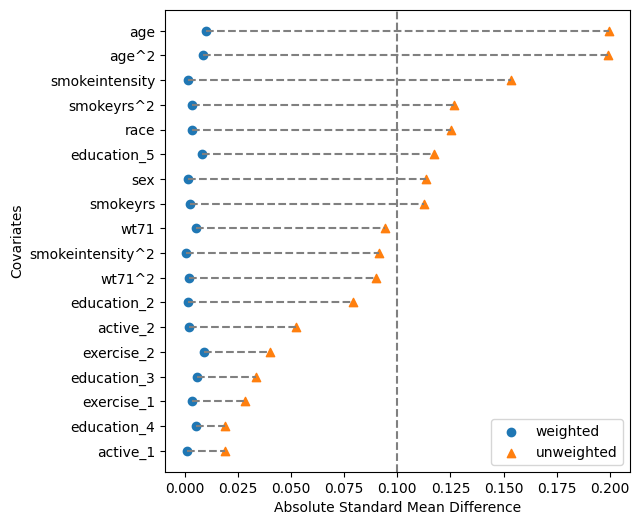

In [12]:
from causallib.evaluation import evaluate
from matplotlib import pyplot as plt

results = evaluate(ipw, data.X, data.a, data.y)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
results.plot_covariate_balance(
    kind="love", ax=ax, thresh=0.1
)  # ASMDのカットオフ値(thresh)を0.1に設定

2. 分散比
   共変量のバランス評価の指標の一つ。処置群と対照群の共変量の分散比。1に近いほどよい。2未満の場合は一般的に許容可能とみなされる
3. 図示
   ヒストグラムなどを使用して傾向スコアの分布を確認する
   以下に、傾向スコアで重み付けをした結果の分布を図示する
   * 分布の重なりが大きい(共有サポート)
   * ほとんどの傾向スコア(横軸)において、処置あり/なしが存在する(正値性を満たす)

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

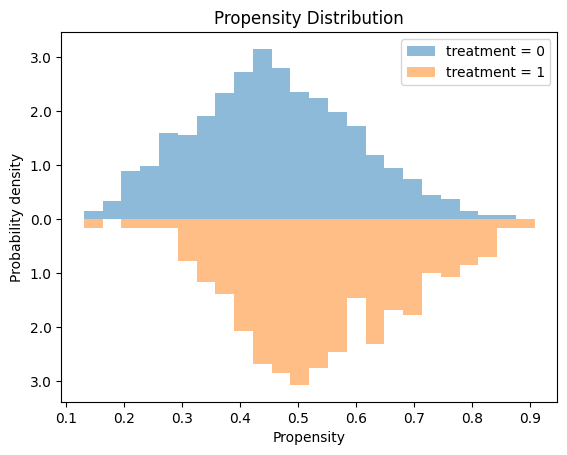

In [13]:
# 図3.20
results.plot_weight_distribution()

* 傾向スコアの注意点: 傾向スコアの予測精度の最大化と、因果推論が適切に行えるかは同義ではない。処置の予測に関係していても、結果変数に無関係の変数があり、このような変数を含めると傾向スコアの分散が増加し、マッチングや重み付けが不安定になる可能性がある

### 3.3.4 傾向スコア分析の課題

1. 未観測の交絡因子への対応
   未観測の交絡因子のバランスは調整できないので、その影響が大きい場合に問題が出る
2. IPWの極端な重み付けへの対応
   特定の個体が処置群、対照群に割り当てられる確率が非常に低い場合、その逆数(重み)が大きくなってしまい結果の信頼性を損なう。これの対策としてクリッピングがある
   * クリッピング(Clipping): あるしきい値(カットオフ値)を超える重みを固定値に抑える
     ただし、バイアスを生じさせる可能性もあるので、適用は慎重に行う

## 3.4 二重にロバストな推定法

### 3.4.1 二重にロバストな推定法の概要

* Doubly Robust estimation: DR
* IPWによる推定と回帰分析による推定の2つの組み合わせ
* 結果変数モデルか、傾向スコアモデルのどちらかが適切に推定できていることが前提

$$
\widehat{ATE}_{DR} =
\frac{1}{N} \sum_{i=1}^{N}
\left(
	\hat{\mu}_i (X_i) + 
	\frac
	{T_i (Y_i - \hat{\mu}_1 (X_i) )}
	{\hat{\pi} (X_i)}
\right)
- \frac{1}{N} \sum_{i=1}^{N}
\left(
	\hat{\mu}_i (X_i) +
	\frac
	{(1 - T_i) (Y_i - \hat{\mu}_0 (X_i))}
	{1 - \hat{\pi} (X_i)}
\right)
$$

* $N$: 全体個数
* $Y_i$: 個体$i$における結果変数
* $T_i$: 個体$i$に対する処置変数
* $X_i$: 個体$i$の共変量
* $\hat{\pi}(X_i)$: 傾向スコアの推定値
* $\hat{\mu_1}(X_i)$: 処置群における結果変数の推定値
* $\hat{\mu_0}(X_i)$: 対照群における結果変数の推定値

1. 結果変数モデルが正しい場合: $Y_{i} \fallingdotseq \hat{\mu}_{1}(X_{i})$。下線部分が$\fallingdotseq 0$となり、傾向スコアの推定値$\hat{\pi}(X_i)$を無視できる

$$
E[Y_{i}] = 

\frac{1}{N}
\sum
\left(
	\hat{\mu}_1 (X_i) + 
	\underline{
		\frac
		{T_i (Y_i - \hat{\mu}_1 (X_i))}
		{\hat{\pi}(X_i)}
	}
\right)
$$

2. 傾向スコアモデルが正しい場合: $T_{i} \fallingdotseq \hat{\pi}(X_{i})$。 1.を式変形する。下線部分が$\fallingdotseq 0$となり、結果変数の推定値$\hat{\mu}_1(X_i)$を無視できる

$$
E[Y_i] = \\
\frac{1}{N}
\sum
\left(
	\frac
	{ \hat{\mu}_1 (X_i) \hat{\pi}(X_i) }
	{ \hat{\pi}(X_i) }
	+ \frac
	{ T_i Y_i }
	{ \hat{\pi}(X_i) }
	- \frac
    { T_i \hat{\mu}_1(X_i) }
	{ \hat{\pi}(X_i) }
\right) = \\

\frac{1}{N}
\sum
\left(
	\frac
	{ T_{i} Y_{i} }
	{ \hat{\pi} (X_i) } -
	\underline{
		\left(
			\frac
			{ T_i - \hat{\pi}(X_i) }
			{ \hat{\pi}(X_i) }
		\right)
		\hat{\mu}_1(X_i)
	}
\right)
$$

### 3.4.2 二重にロバストな推定法の実行手順

#### Step 1 ライブラリの準備、データの準備

causallib==0.9.5を使用


In [14]:
from causallib.datasets import load_nhefs

data = load_nhefs()

#### Step 2 DAGの確認

傾向スコアと同じ

#### Step 3 識別仮定の確認: IPWの実行と同様


* 識別仮定の確認
  * 回帰分析を使用した場合の仮定
  * 傾向スコアを使用したIPWと同様の識別仮定を満たすか

上記の確認が必要。今回は満たすとし、以下の3つのクラスを使う

* IPW: ロジスティック回帰モデルを使用
* StratifiedStandardization: データを層別化して、各層の平均処置効果を計算
* AIPW: 上記2つの手法の組み合わせ。ロバストな因果効果の推定

本来ここで正値性の確認や共変量バランスの評価も行うが、前項でやったので割愛


In [15]:
from causallib.estimation import AIPW, IPW, StratifiedStandardization
from sklearn.linear_model import LinearRegression, LogisticRegression

# clip_max=0.95: 傾向スコアの推定値がこの値を超える場合は0.95にclipする
# clip_min=0.05: 傾向スコアの推定値がこの値を下回る場合は0.05にclipする
ipw = IPW(LogisticRegression(solver="liblinear"), clip_min=0.05, clip_max=0.95)

std = StratifiedStandardization(LinearRegression())

dr = AIPW(std, ipw)
dr.fit(data.X, data.a, data.y)

AIPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.5/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, outcome_covariates=None, outcome_model=StratifiedStandardization(learner=LinearRegression()), overlap_weighting=False, predict_proba=False, weight_covariates=None,
     weight_model=IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.5/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=0.95, clip_min=0.05, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear')))

#### Step 4 因果効果の推定: IPWの結果を活用してDRにより因果効果を推定
結果変数の期待値$E[Y(1)]$と$E[Y(0)]$を確認

In [16]:
population_outcome = dr.estimate_population_outcome(data.X, data.a, data.y)
print(f"結果変数(体重)の期待値(1:禁煙, 2:喫煙):\n{population_outcome}\n")

effect = dr.estimate_effect(population_outcome[1], population_outcome[0])
print(f"因果効果:\n{effect}")

結果変数(体重)の期待値(1:禁煙, 2:喫煙):
qsmk
0    1.765099
1    5.204596
dtype: float64

因果効果:
diff    3.439497
dtype: float64


#### Step 5 結果の評価

11年間で禁煙をしたほうが体重の増加が3.4kgほど多い

### 3.4.3 二重にロバストな推定法の課題

1. 結果変数モデルが適切でない場合への対応
   理論上は結果変数モデルか、傾向スコアモデルのどちらかが適切に推定できていれば因果効果を推定できると言われているが、実態として以下の課題がある

   * 結果変数モデルが不適切な場合に大きなバイアスを引き起こす場合がある
   * 結果変数モデルと傾向スコアモデルの療法が少しでも間違っているとバイアスと分散が大きくなる可能性がある

   ただし、両方のモデルが正確な場合、少なくともサンプルサイズが大きければDR推定量はIPWよりも分散が小さくなる
2. 選択バイアスとみかん足の交絡因子への対応(回帰分析や、傾向スコア分析と同様)

## 3.5 自然実験(準実験)の全体像

自然実験(Natural experiment), 準実験(quasi-experiment): RCTを実施していない状況でも、RCTに相当する事象の発生を利用して因果効果を推定する方法

* 回帰不連続デザイン(Regression Discontinuity Desgin: RDD)
* 操作変数法(Instrumental Variable methods: IV)
* 差分の差分法: (Differences-Differences: DiD)
* 合成コントロール法(Synthetic Control methods: SC)

## 3.6 回帰不連続デザイン

### 3.6.1 回帰不連続デザインの概要

試験の合格点など強制的なカットオフがある状況で主に使用する。カットオフ値c近傍では、ほぼ状況が同じにも関わらず処置群と対照群が両方存在するため、RCTに近い状況が作り出されていると言える。

* 処置$T_i$は関数で表される(特にsharp RDDではカットオフ値cより大きいか、小さいかで場合分け)
  * このとき、$X_i$を強制変数(forcing variable)と呼ぶ

$$
Y_{i}=\begin{cases}Y_{i}(0),\enspace i f\,X_{i}<c\\ Y_{i}(1),\enspace i f\,X_{i}\geq c\end{cases}
$$

この式において、カットオフ値cにおける平均処置効果ATEは以下であり、cにおける2つの回帰局線の間の垂直距離となる

$$
ATE(X)=E[Y_i(1)|X_i=c] - E[Y_i(0)|X_i=c]
$$

![図3.23](images/chap3/image-6.png)

図3.23を見てもわかるように、sharp RDDで推定した処置効果は$E[Y_{i}(1)|X_{i}=c] - E[Y_{i}(0)|X_{i}=c]\equiv\mu_{+}-\mu_{-}$となっており、sharp RDDの因果効果の定義は$\delta_{SRD} = E[ Y_i(1) - Y_i(0) | X_i = c ]$と定義される。

### 3.6.2 回帰不連続デザインｎの実行手順

* オンライン健康プラットフォームの新規顧客獲得戦略の影響評価
* 健康スコアが一定のカットオフ値以上の人には初月無料を提供
* この戦略の、ユーザーのサービス利用時間への影響を評価する
* $Y$: ユーザーのサービス利用期間(時間/日)
* $X$: 健康スコア(-1~1の範囲)
* $treatment(T)$: 初月無料プロモーションを受けたか(1: yes, 0: no)
* カットオフ値は今回0とする

#### Step 1 ライブラリの準備、データの確認

以下のライブラリをインストールしておく

* rdrobust
* rddensity


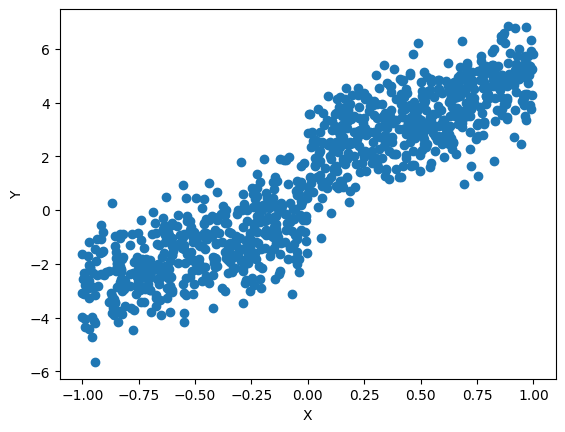

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rng = np.random.default_rng(0)

# サンプルデータの生成
n = 1000  # サンプルサイズ
X = rng.uniform(-1, 1, n)  # 強制変数
CUTOFF = 0
treatment = (X > CUTOFF).astype(int)  # 処置の割当
Y = 3 * X + 2 * treatment + rng.normal(size=n)  # 結果変数

# データフレームに変換
data_df = pd.DataFrame({"Y": Y, "X": X, "treatment": treatment})

plt.scatter(data_df["X"], data_df["Y"])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#### Step 2 DAGの確認

![図3.24](images/chap3/image-7.png)

#### Step 3 識別仮定の確認

1. 処置群と対照群の識別仮定を確認
   * 基本的な識別仮定の確認
     * 条件付き:独立性: 健康スコアで条件付けているので、サービス利用時間とプロモーションの有無は独立
     * 相互作用なし(NI): 処置群と対照群は互いに干渉しない
     * 一致性(処置の定義が十分具体的・定量的かつ、実際の処置が想定の処置と一致するか): カットオフ値近傍において、強制変数$X_i$の個体がプロモーションを実際に受けたときの結果は、プロモーションを受けた場合の潜在的な結果に一致する
   * 条件付き正値性を満たすかの確認
     * 強制変数が連続値の場合、カットオフ値の位置では厳密に正値性を満たすことは困難
     * 2.の連続性の仮定を満たすことで、局所的な平均処置効果(Local Average Effect: LATE)を推定する
2. 連続性の仮定の確認
   * RDDでは連続性の仮定を満たす必要がある
   * 連続性の仮定を式で表す
     条件付き期待値

     * $E[Y_i(1) | X_i = x]$
     * $E[Y_i(0) | X_i=x]$
       が、$x=c$で連続ならば、次式が成り立つこと

     $$
     \tau_{LATE}
     = E[ Y_i(1) - Y_i(0) | X_i = c ]
     = \lim_{x \downarrow c} E[ Y_i | X_i = x]
     - \lim_{x \uparrow c } E[ Y_i | X_i =x]
     $$

     $E[Y_i | X_i = x]$がカットオフ値cにおいて連続関数である場合、処置群と対照群の$E$の極限値($x \uparrow c, x \downarrow c$)での差が、カットオフ値における平均処置効果に等しいことを表す
   * 確認方法

     1. カットオフ値付近の個体の分布の確認
        カットオフ近傍の観測値の数が急激に変化するようなRDDは、層でない場合と比べて信憑性が低くなる傾向がある
     2. カットオフ値付近の連続性の検定
        統計的検定により、カットオフ近傍において、確率密度関数が連続かを検定する

        * 帰無仮説: 連続である
        * 対立仮説: 連続でない

        rdddensityを使う


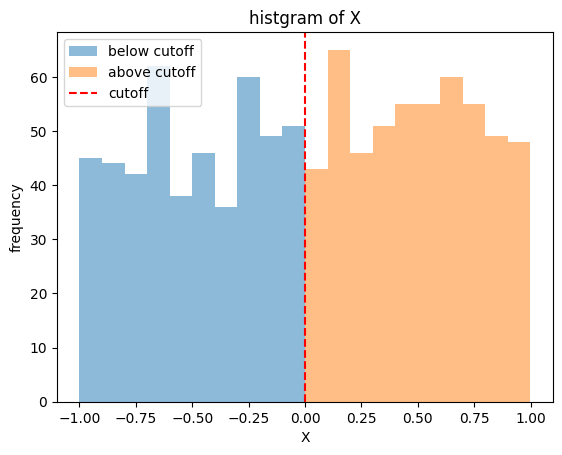

In [18]:
# カットオフ値付近の個体の分布の確認
plt.hist(data_df[data_df["X"] < CUTOFF]["X"], bins=10, alpha=0.5, label="below cutoff")
plt.hist(data_df[data_df["X"] >= CUTOFF]["X"], bins=10, alpha=0.5, label="above cutoff")
plt.axvline(x=CUTOFF, color="r", linestyle="--", label="cutoff")
plt.xlabel("X")
plt.ylabel("frequency")
plt.title("histgram of X")
plt.legend()
plt.show()

In [19]:
# カットオフ値付近のレン属性の検定
import rddensity

rddensity.rddensity(X, c=CUTOFF)

Manipulation testing using local polynomial density estimation
Number of obs:                              1000
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 0                               Left of c             Right of c
Number of obs:                            473                    527
Eff. number of obs:                       230                    234
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                0.4671                 0.4466

Method:                                     T                P > |T|
Robust                                 0.2459                 0.8057

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

p値 = 0.8057 > 0.05のため、帰無仮説(確率密度関数が連続)は棄却されない

#### Step 4 因果関係の推定

3. バンド幅(band width)の選択

   * バンド幅: 因果効果の推定の対象範囲。カットオフ値からどの範囲までを推定に使用するかを決める必要がある

     * バンド幅が小さい: カットオフ値近傍だけ使う。バイアスが小さくなるが、データ数が少なく分散が大きくなる
     * バンド幅が大きい: バイアスが大きくなるが、分散が小さくなる
   * バイアスと分散の両方を考慮して、MSE(最小二乗誤差)を使用し、これを最小化する

     1. バンド幅の設定
     2. 回帰分析で推定値を算出
     3. バンド幅内の結果変数のMSEを計算
        これをMSEが最小になるまで繰り返す
   * MSEの計算には実測値と推定値の両方が必要

     * 推定値を計算するには
     * 局所多項式回帰(local polynominal regression)
     * 局所回帰の中で特に一般的なのがLOWESS(locally weighted scatterplot smoothing)
     * LOWESSでカーネル密度推定を使用することで、カットオフ値近傍に重み付けをした回帰が可能
     * カーネル関数は、三角関数が推奨されている(カットオフ値近傍の重みが大きくなる)

4. 処置効果の推定
   rdrobustを使用して確認する。
   * Bandwidth Estimationが0.336になっている
   * Coef.(因果効果)が1.761 → プロモーションありの顧客は1.76時間利用時間が長い


In [20]:
import rdrobust

rdrobust.rdrobust(Y, X, c=CUTOFF)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           473        527
Number of Unique Obs.            473        527
Number of Effective Obs.         172        170
Bandwidth Estimation           0.336      0.336
Bandwidth Bias                 0.546      0.546
rho (h/b)                      0.616      0.616

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       1.761    0.296    5.952   2.648e-09      [1.181, 2.34]
Robust                 -        -    4.818   1.451e-06     [0.993, 2.355]


#### Step 5 結果の評価

1. RDプロットの確認
   散布図をいくつかの幅で区切ったグループの平均値を計算。その平均値と、平均値をスムーズ化した曲線野グラフを確認する


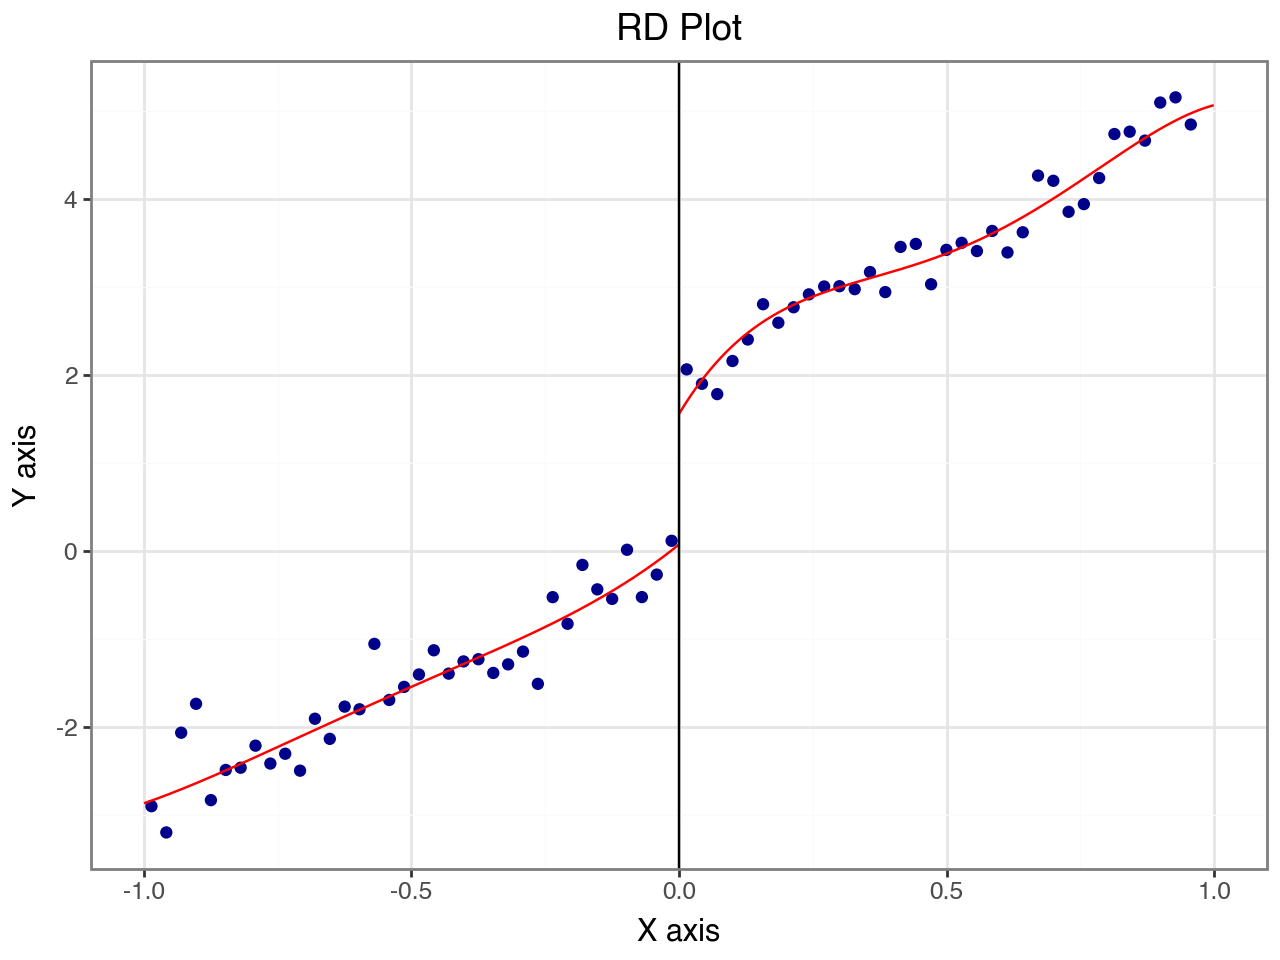

Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           473        527
Number of Effective Obs          473        527
Bandwith poly. fit (h)           1.0      0.999
Number of bins scale               1          1
Bins Selected                     36         35
Average Bin Length             0.028      0.029
Median Bin Length              0.028      0.029
IMSE-optimal bins                9.0       11.0
Mimicking Variance bins         36.0       35.0

Relative to IMSE-optimal:
Implied scale                    4.0      3.182
WIMSE variance weight          0.015       0.03
WIMSE bias weight              0.985       0.97


In [21]:
rdrobust.rdplot(Y, X, c=CUTOFF)

2. プラセボテスト
   RDDによる推定の妥当性を確認する方法の1つ。
   * カットオフ値cからある程度離れたところに、プラセボのカットオフ値を仮定する
   * その近傍で因果効果推定をし、比較する
   
   これにより、当初設定したカットオフ値cでの効果が偶然かどうかをテストする

   カットオフを+0.5してプラセボテストした結果、Coefが0.274となった。P値(P>|t|)が0.4093と有意水準より大きいため、因果効果がないという帰無仮説が支持される。

RDDでは共変量を追加したり、ベイズモデリングを使用した分析も可能

In [22]:
rdrobust.rdrobust(Y, X, c=CUTOFF + 0.5)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           733        267
Number of Unique Obs.            733        267
Number of Effective Obs.          93         99
Bandwidth Estimation            0.17       0.17
Bandwidth Bias                 0.283      0.283
rho (h/b)                      0.603      0.603

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.274    0.332    0.825   4.093e-01    [-0.377, 0.925]
Robust                 -        -    0.985   3.246e-01    [-0.381, 1.151]


### 3.6.3 回帰不連続デザインの課題

1. カットオフ値近傍でのみ使用できる推定方法
2. カットオフ近傍にデータが十分必要
3. カットオフ値を集団や個人が操作できる場合は結果の解釈が困難

## 3.7 操作変数

### 3.7.1 操作変数法の概要

操作変数法(Instrumental Variable methods: IV)

* 傾向スコア分析と異なり、未観測の交絡因子に対処する
* 操作変数Zを用いて、解説的にRCTに近い状況を作る
* 操作変数は処置変数のみに影響を与え、結果変数に直接影響を与えない
* 結果変数Y、共変量X、処置変数Tに対して、操作変数Zは以下の仮定を満たす

  1. ZとTは関連する$(Cov(Z, T) \neq 0)$
  2. Zは、T経由以外ではYに影響を与えない(除外制約)
  3. ZとYは共通の原因(Common causes)を持たない

  さらに、以下の仮定を追加すると因果効果を定量的に評価できる
  4. SUTVA
  5. 単調性 (Monotonicity): 反抗者(Defier)がいないこと

ここで具体的な例として、教育が所得に与える影響を推定することを考える

* 結果変数: 将来の所得$Y_i$
* 処置変数: 特定の教育$T_i$
* 交絡因子: 生徒の能力$C_i$

![図3.28](images/chap3/image-8.png)

交絡因子Cがあるため、T→Yの因果効果の推定が困難。そのため操作変数を導入する

* 操作変数: 教育制度の変更、生まれた時期など$Z_i$。教育Tには影響を与えるが、所得Yに影響は与えないと考えられる

![図3.29](images/chap3/image-9.png)

ここで各変数間に線形性があると仮定して、2段階最小二乗法(two-step least-squares method: 2SLS)を使用する。

* $Z \rightarrow Y$への効果係数を$\beta_{ZY}$
* $Z \rightarrow T$への効果係数を$\beta_{ZT}$
* $T \rightarrow Y$への効果係数を$\beta_{TY}$

と置くと、線形性から

$$
{{T_{i}=\alpha_{1}+\beta_{ZT}Z_{i}+\varepsilon_{1i}}} \\
{{Y_{i}=\alpha_{2}+\beta_{TY}T_{i}+\varepsilon_{2i}}}
$$

となり、$Y_i$について式変形すると、

$$
\begin{align}
Y_{i}
&= \alpha_{2}
+ \beta_{TY} \left( \alpha_{1}+\beta_{ZT} Z_{i} + \varepsilon_{1i} \right)
+ \varepsilon_{2i} \nonumber \\
&= \alpha_2 + \beta_{TY} \alpha_1 + \beta_{TY} \beta_{ZT} Z_i +\beta_{TY}\varepsilon_{1i} + \varepsilon_{2i} \nonumber
\end{align}
$$

共分散$Cov(Y_i, Z_i)$は以下となる。($W = \beta_{TY} \varepsilon_{1} + \varepsilon_{2}$とおく)

$$
\begin{align}
Cov(Y,Z)
&= E \left[ (Y - E(Y)) \times (Z - E(Z)) \right] \nonumber \\
&= E \left[
    (\alpha_2 + \beta_{TY} \alpha_1 + \beta_{TY} \beta_{ZT} Z + W - E(Y) )( Z - E(Z) )
\right] \nonumber \\
\end{align}
$$

ここで、$E[Y]=\alpha_2 + \beta_{TY} \alpha_{1} + \beta_{TY}\beta_{ZT}E[Z]$なので、

$$
\begin{align}
Cov(Y,Z)
&= \beta_{TY} \beta_{ZT}
  \times E \left[(Z - E(Z)) (Z - E(Z)) \right]
       + E \left[W(Z - E(Z)) \right] \nonumber \\
&= \beta_{TY} \beta_{ZT} Var(Z)
       + E \left[W(Z - E(Z)) \right] \nonumber
\end{align}
$$

誤差項と$Z_i$は独立と仮定すると、$E[W(Z - E(Z))] = 0$となるので、

$$
\begin{align}
Cov(Y, Z) &= \beta_{TY} \beta_{ZT}Var(Z) \nonumber \\
同様にCov(T, Z) &= \beta_{ZT} Var(Z) \nonumber \\
\end{align}
$$

これを$\beta_{TY}$について解くと、

$$
\beta_{TY} = \frac{Cov(Y, Z)}{Cov(T, Z)} \nonumber
$$

それぞれの共分散CovをZの分散$Var(Z_i)$で割ると、

$$
\beta_{TY} = \frac{\frac{Cov(Y, Z)}{Var(Z_i)}}{\frac{Cov(T, Z)}{Var(Z_i)}}
$$

となる。ここで、

* $\frac{Cov(Y, Z)}{Var(Z)}$はZに対するYの回帰係数
* $\frac{Cov(T, Z)}{Var(Z_i)}$はZに対するTの回帰係数

なので、

$$
\beta_{TY}= \frac{\beta_{ZY}}{\beta_{ZT}}
$$

になる。

ここまでの計算で、$\beta_{TY}$(推定量として$\beta_{2SLS}$と読み替える)を推定するには、$\beta_{ZY}$と$\beta_{ZT}$が必要ということがわかった。

または、以下の2段階の回帰分析の式をもとに導出すると

1. $\hat{T_i} = \alpha_1 + \beta_{ZT} Z_i + \varepsilon_{1i} \ (Z \rightarrow T)$
2. $Y_i = \alpha_2 + \beta_{2SLS} \hat{T_i} + \varepsilon_{2i} \ (T \rightarrow Y)$

$$
\beta_{TY} = \beta_{2SLS}
= \frac{Cov(Y, \hat{T})}{Var(\hat{T})}
=\frac{Cov(Y, \alpha_1 + \beta_{ZT} Z)}{Var(\alpha_1 + \beta_{ZT}Z)}
=\frac{\beta_{ZT} Cov(Y, Z)}{\beta_{ZT}^2 Var(Z)}
=\frac{\beta_{ZY}}{\beta_{ZT}}
$$

$\beta_{2SLS}(\beta_{TY})$は具体的に言うと局所平均因果効果(Compiler Average Causal Effect: CACE, もしくはLocal Average Treatment Effect: LATE)を指す。

#### CACE/LATEとは

* $T_i$: 処置変数(1/0)
* $D_i$: 実際に処置を受けたか(1/0)

| $T_i = 0$のとき |              $D_i = 1$              |      $D_i = 0$      |     $D_i = 1$     |                $D_i=0$                |
| :---------------: | :------------------------------------: | :--------------------: | :------------------: | :--------------------------------------: |
| $T_i = 1$のとき |              $D_i = 1$              |      $D_i = 1$      |     $D_i = 0$     |               $D_i = 0$               |
|     パターン     | Always-Taker<br />(常に処置を受ける人) | Complier<br />(遵守者) | Defier<br />(反抗者) | Never-Talker<br />(常に処置を受けない人) |

この４つのパターンの中で反抗者のみ、処置変数$T_i$が$D_i$に真逆の影響を与えるので、操作変数を導入した目的に沿わなくなる。そこで、操作変数は単調性を仮定している。

$$
D_i(T_i = 1) \geq D_i(T_i = 0)
$$

これにより、推定する処置効果は、遵守者へのATEに限定される(局所)。そのためCATE/LATEという。

### 3.7.2 操作変数法の実行手順

問題設定: 運動量が健康指標に与える影響はどの程度か?

#### Step 1 ライブラリの準備・データの確認


In [23]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# 乱数シードの設定
rng = np.random.default_rng(0)

# サンプルデータの生成
N = 1000  # サンプルサイズ
Z = rng.normal(size=N)  # 操作変数
U = rng.normal(size=N)  # 誤差項
T = Z + rng.normal(size=N)  # 処置変数
Y = T + U  # 結果変数

# データフレームに変換
data_df = pd.DataFrame({"Y": Y, "T": T, "Z": Z, "u": U})

# 結果変数を定義
Y = data_df["Y"]

# 処置変数を定義
T = sm.add_constant(data_df["T"])

# 操作変数を定義
Z = sm.add_constant(data_df["Z"])

#### Step 2 DAGの確認

* 結果変数: 地域別の健康指標の平均値(BMIなどを総合評価した数値)
* 処置変数: 地域別の運動量の平均値(週何時間運動するか)
* 操作変数: 運動キャンペーンの規模(金額)/地域人口

それぞれ負の値を取りうるとする

![図3.32](images/chap3/image-10.png)

#### Step 3 識別仮定の確認

1. ZとTは関連する
2. Zは、Tを通して以外にはYに影響を与えない
3. ZとTは共通の原因を持たない
4. SUTVA
5. 単調性

#### Step 4 因果効果の推定

In [24]:
from statsmodels.sandbox.regression.gmm import IV2SLS

# 操作変数法を適用
iv = IV2SLS(Y, T, Z).fit()

#### Step 5 結果の評価

地域の平均運動量が1増えると、その地域の平均健康指標(coef)が1.0650増える事がわかる。またp値=0である。

In [25]:
iv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.650
Model:                         IV2SLS   Adj. R-squared:                  0.650
Method:                     Two Stage   F-statistic:                     927.6
                        Least Squares   Prob (F-statistic):          1.36e-144
Date:                Sat, 21 Sep 2024                                         
Time:                        12:01:41                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.033     -0.059      0.953      -0.066       0.062
T              1.0650      0.035     30.456      0.000       0.996       1.134
==============================================================================
Omnibus:                        1.617   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.651
Skew:                          -0.063   Prob(JB):                        0.438
Kurtosis:                       2.847   Cond. No.                         1.36
==============================================================================
"""

### 3.7.3 操作変数法の課題

1. 操作変数は処置変数と強い因果関係がある必要がある。このような操作変数を見つけるのは困難かつ、除外制約(結果関数と直接関連性を持たない)を満たすことの確認が必要。
2. 処置変数との相関が弱い、弱操作変数(weak instrument)を用いた場合に推定の信頼性がない。処置変数が1つの場合はその強さを、F検定統計量で判定できる。


#### その他のIV

1. 一般化した操作変数法
2. LIML (Limited Informatioin Maximum Likelihood)
3. GMM (Generalized Method of Mements)
4. ノンパラメトリックIV

## 3.8 差分の差分法
### 3.8.1 差分の差分法の概要

* 差分の差分法(Difference-in-Differences: DID)
  1. 処置群と対照群それぞれに対し、処置前後のデータの差分をとる
  2. その結果の差分を取る

![図3.34](images/chap3/image-11.png)

時系列の影響による結果変数の変化のトレンドと、処置の影響を切り分ける。

未観測の交絡因子を除くために、以下の2つの仮定を満たす必要がある
1. 並行トレンド仮定: もし処置が行われなかったら、処置群と対照群の時系列変化は同じ(トレンドが平行)である
2. 共通ショック仮定: 測定期間中に結果変数に影響を与えるような「別のイベント」が発生していない、もしくは発生していても処置群/対照群の両方に同様に影響している

### 3.8.2 差分の差分法の実行

問題設定: 新しいマーケティング施策の売り上げ増加効果はどの程度か?

#### Step 1 ライブラリの準備、データの確認

CausalPyを使用する


In [26]:
import causalpy as cp

data = cp.load_data("did")
data.head()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,group,t,unit,post_treatment,y
0,0,0.0,0,False,0.897122
1,0,1.0,0,True,1.961214
2,1,0.0,1,False,1.233525
3,1,1.0,1,True,2.752794
4,0,0.0,2,False,1.149207


#### Step 2 DAGの確認

* 結果変数: 販売額[百万円]
* 処置関数: 新しいマーケティング施策の実施

![図3.35](images/chap3/image-12.png)

#### Step 3 識別仮定の確認
* 並行トレンド仮定
* 共通ショック仮定

データの可視化や、背景の理解により確認できたとする

#### 因果効果の推定

線形回帰モデル(sklearn.linear_model.LinearRegression)を使用して、処置群と対照群それぞれのデータに対し、モデルをフィッティングする


/Users/sean/Documents/myscript/causal-inference-basic-book/.venv/lib/python3.11/site-packages/matplotlib/text.py:1467: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/Users/sean/Documents/myscript/causal-inference-basic-book/.venv/lib/python3.11/site-packages/matplotlib/text.py:1467: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/Users/sean/Documents/myscript/causal-inference-basic-book/.venv/lib/python3.11/site-packages/matplotlib/text.py:898: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depre

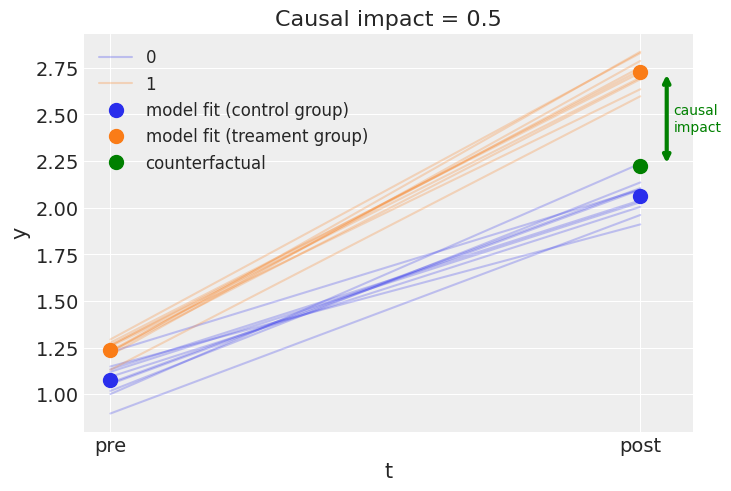

In [27]:
from sklearn.linear_model import LinearRegression

result = cp.DifferenceInDifferences(
    data,
    # モデルの式
    # yは結果変数
    # 1は定数項
    # group * post_treatmentは処置効果を表す交互作用項
    # group=1かつpost_treatment=Trueのときに1になる
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",  # グループ変数(処置群/対照群かの変数名)
    treated=1,
    untreated=0,
    model=LinearRegression(),
)

fig, ax = result.plot()


#### Step 5 結果の評価

Causal impact 0.5とあるので0.5[百万円] = 50万円。つまり新しいマーケティング施策により、1店舗あたりの売り上げを50万円増加させる効果があるといえる。

### 3.8.3 差分の差分法の課題

並行トレンド仮定と共通トレンド仮定を設定し、条件付き独立性を満たすことで、本来はATT(処置群に対する平均因果効果)であるところを、ATEとみなしている。

現実の問題ではこれらの仮定を満たすことを示すのは困難。

また、処置群と対照群で告示した個体を探した結果、
DiDを行う際のマッチングがうまくできないこともある。

次節の合成コントロール法でこれらの仮定を緩和する。

## 3.9 合成コントロール法

### 3.9.1 合成コントロール法の概要

合成コントロール法(Synthetic Control Method: SC)

* 処置群、もしくは対照群どちらかのサンプル数が少数の場合も他方の群内の個体の組み合わせにより適切な比較を行う
* 並行トレンド仮定や、共通ショック仮定を緩和できる
* 処置群が$n=1$, 対照群が$n>1$の場合を仮定する。対照群から処置群と類似した分析対象のデータを選び、それらに対し重み$\omega_i$を使って加重平均したものを、反実仮想データとして用いる
* $\omega_i (\Sigma\omega_i = 1)$: 加重平均する際の重み
* $N$: 処置群のサンプル数 + 対照群のサンプル数
* $t$: 時点
* $D$: 処置が行われた時点
* $Y_{N, t}(1)$: 処置群の結果変数
* $Y_{i, t}(0) \ (i = 1, 2, \dots, N - 1)$: 対照群の結果変数
* $\omega_i$は以下の式を求める($\hat\omega$を最小化する)ことで推定する

$$
\hat{\omega} 
= \underset{\omega \geq 0,\sum_i \omega_i = 1}{arg\,min}
\sum_{t=1}^{D-1}
\left(
	Y_{N,t}
	- \sum_{i=1}^{N - 1} \omega_i Y_{i,t}
\right)
$$


* 推定した$\omega_i$を用いで処置群に近い合成対照群を作成し、差分をとると因果効果$\tau_t$を推定できる
* 合成対照群は各サンプルに重み付けしたものであり、解釈が容易

#### 具体的な分析例

Proposition 99のデータを使用する: 1988年にカリフォルニア州で施行されたタバコ税及び健康保護法のデータ


In [51]:
from pathlib import Path

import pandas as pd

prop_99_path = Path("../../data/chap3/proposition 99.csv")

prop_99_df = pd.read_csv(
    prop_99_path, header=0, index_col="year", usecols=["year", "state", "cigsale"]
)
processed_df = prop_99_df.pivot_table(index="year", columns="state", values="cigsale")
processed_df = processed_df.set_axis(
    [x.replace(" ", "_") for x in processed_df.columns], axis=1
)

treated_state = "California"
other_states = " + ".join(processed_df.columns[processed_df.columns != treated_state])
treatment_time = 1988  # proposition 99の施行年

processed_df

,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New_Hampshire,New_Mexico,North_Carolina,North_Dakota,Ohio,Oklahoma,Pennsylvania,Rhode_Island,South_Carolina,South_Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West_Virginia,Wisconsin,Wyoming
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970,89.8,100.3,123.0,124.8,120.0,155.0,109.9,102.4,124.8,134.6,108.5,114.0,155.8,115.9,128.5,104.3,93.4,121.3,111.2,108.1,189.5,265.7,90.0,172.4,93.8,121.6,108.4,107.3,123.9,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
1971,95.4,104.1,121.0,125.5,117.6,161.1,115.7,108.5,125.6,139.3,108.4,102.8,163.5,119.8,133.2,116.4,105.4,127.6,115.6,108.6,190.5,278.0,92.6,187.6,98.5,124.6,115.4,106.3,123.2,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
1972,101.1,103.9,123.5,134.3,110.8,156.3,117.0,126.1,126.6,149.2,109.4,111.0,179.4,125.3,136.5,96.8,112.1,130.0,122.2,104.9,198.6,296.2,99.3,214.1,103.8,124.4,121.7,109.0,134.4,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
1973,102.9,108.0,124.4,137.9,109.3,154.7,119.8,121.8,124.4,156.0,110.6,115.2,201.9,126.7,138.0,106.8,115.0,132.1,119.9,106.6,201.5,279.0,98.9,226.5,108.7,120.5,124.1,110.7,142.0,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
1974,108.2,109.7,126.7,132.8,112.4,151.3,123.7,125.6,131.9,159.6,116.1,118.6,212.4,129.9,142.1,110.6,117.1,135.4,121.9,110.5,204.7,269.8,100.3,227.3,110.5,122.1,130.5,114.2,146.1,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8
1975,111.7,114.8,127.1,131.0,110.2,147.6,122.9,123.3,131.8,162.4,120.5,123.4,223.0,133.6,140.7,111.5,116.8,135.6,123.7,114.1,205.2,269.1,103.1,226.0,117.9,122.5,132.9,114.6,154.7,130.5,113.5,117.4,116.0,75.8,155.5,152.7,123.2,113.5,160.7
1976,116.2,119.1,128.0,134.2,113.4,153.0,125.9,125.1,134.4,166.6,124.4,127.7,230.9,139.6,144.9,116.7,120.9,139.5,124.9,118.1,201.4,290.5,102.4,230.2,125.4,124.6,138.6,118.8,150.2,136.8,116.7,121.7,121.4,77.9,171.1,158.1,129.7,115.4,161.5
1977,117.1,122.6,126.4,132.0,117.3,153.3,127.9,125.0,134.0,173.0,125.5,127.9,229.4,140.0,145.6,117.2,122.1,140.8,127.0,117.7,190.8,278.8,102.4,217.0,122.2,127.3,140.4,120.1,148.8,137.2,115.6,124.6,124.2,78.0,169.4,157.7,133.9,117.2,160.4
1978,123.0,127.3,126.1,129.2,117.5,155.5,130.6,122.8,136.7,150.9,127.1,127.1,224.7,142.7,143.9,118.9,124.9,141.8,127.2,117.4,187.0,269.6,103.1,205.5,121.9,131.3,143.6,122.3,146.8,140.4,116.9,127.3,126.6,79.6,162.4,155.9,131.6,116.7,160.3


==================================Pre-Post Fit==================================
Formula: California ~ 0 + Alabama + Arkansas + Colorado + Connecticut + Delaware + Georgia + Idaho + Illinois + Indiana + Iowa + Kansas + Kentucky + Louisiana + Maine + Minnesota + Mississippi + Missouri + Montana + Nebraska + Nevada + New_Hampshire + New_Mexico + North_Carolina + North_Dakota + Ohio + Oklahoma + Pennsylvania + Rhode_Island + South_Carolina + South_Dakota + Tennessee + Texas + Utah + Vermont + Virginia + West_Virginia + Wisconsin + Wyoming
Model coefficients:
  Alabama       	   1.3e-16
  Arkansas      	   2.8e-16
  Colorado      	         0
  Connecticut   	      0.51
  Delaware      	      0.15
  Georgia       	      0.23
  Idaho         	         0
  Illinois      	         0
  Indiana       	   6.8e-16
  Iowa          	         0
  Kansas        	   4.2e-17
  Kentucky      	         0
  Louisiana     	   3.7e-16
  Maine         	         0
  Minnesota     	         0
  Mississippi   	 

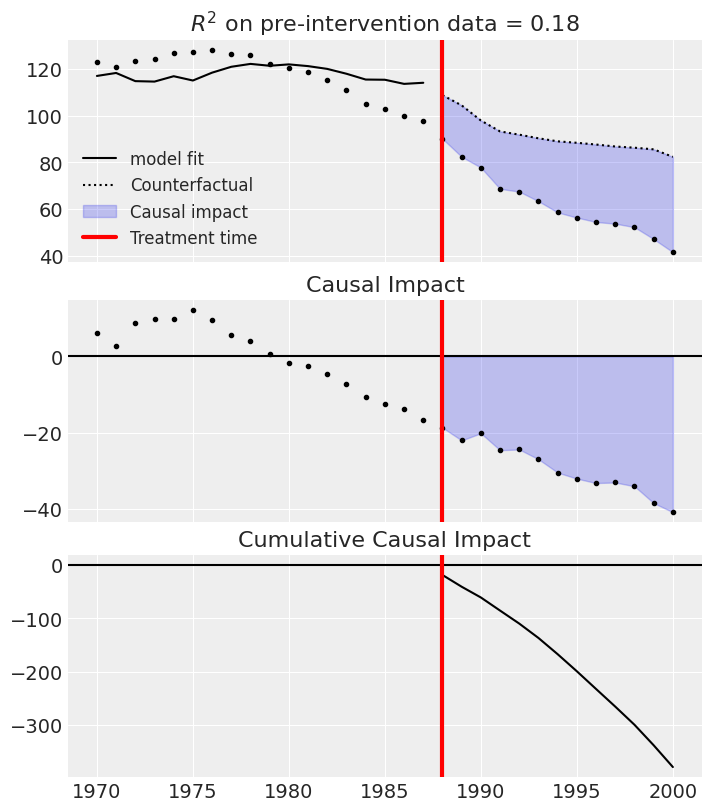

In [39]:
import causalpy as cp

result = cp.SyntheticControl(
    data=processed_df,
    treatment_time=treatment_time,
    formula=f"{treated_state} ~ 0 + {other_states}",
    model=cp.skl_models.WeightedProportion(),  # 重み付け比例モデル
)

result.summary()
fig, ax = result.plot(prot_predictors=True)

# いまいちフィッティングがうまく行っていない?

==================================Pre-Post Fit==================================
Formula: California ~ 0 + Alabama + Arkansas + Colorado + Connecticut + Delaware + Georgia + Idaho + Illinois + Indiana + Iowa + Kansas + Kentucky + Louisiana + Maine + Minnesota + Mississippi + Missouri + Montana + Nebraska + Nevada + New_Hampshire + New_Mexico + North_Carolina + North_Dakota + Ohio + Oklahoma + Pennsylvania + Rhode_Island + South_Carolina + South_Dakota + Tennessee + Texas + Utah + Vermont + Virginia + West_Virginia + Wisconsin + Wyoming
Model coefficients:
  Alabama       	         0
  Arkansas      	         0
  Colorado      	     0.026
  Connecticut   	      0.47
  Delaware      	         0
  Georgia       	         0
  Idaho         	         0
  Illinois      	      0.04
  Indiana       	         0
  Iowa          	         0
  Kansas        	     0.049
  Kentucky      	         0
  Louisiana     	         0
  Maine         	         0
  Minnesota     	         0
  Mississippi   	 

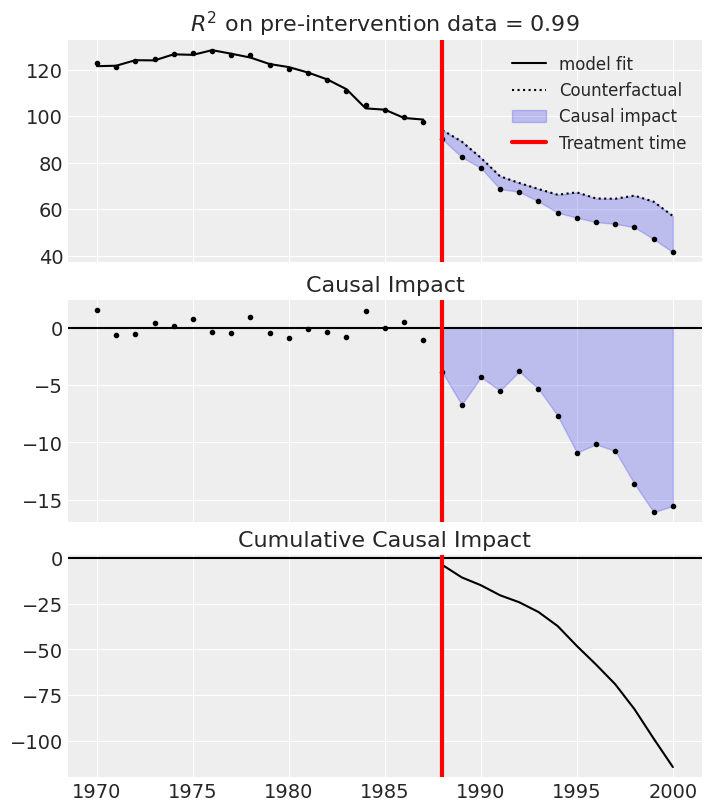

In [40]:
import causalpy as cp
from sklearn.linear_model import LinearRegression

result = cp.SyntheticControl(
    data=processed_df,
    treatment_time=treatment_time,
    formula=f"{treated_state} ~ 0 + {other_states}",
    model=LinearRegression(positive=True),  # 線形回帰モデル(正の値のみを予測)
)

result.summary()
fig, ax = result.plot(prot_predictors=True)

# 線形回帰モデルのほうがフィットしている

==================================Pre-Post Fit==================================
Formula: California ~ 0 + Alabama + Arkansas + Colorado + Connecticut + Delaware + Georgia + Idaho + Illinois + Indiana + Iowa + Kansas + Kentucky + Louisiana + Maine + Minnesota + Mississippi + Missouri + Montana + Nebraska + Nevada + New_Hampshire + New_Mexico + North_Carolina + North_Dakota + Ohio + Oklahoma + Pennsylvania + Rhode_Island + South_Carolina + South_Dakota + Tennessee + Texas + Utah + Vermont + Virginia + West_Virginia + Wisconsin + Wyoming
Model coefficients:
  Alabama       	         0
  Arkansas      	         0
  Colorado      	     0.038
  Connecticut   	      0.17
  Delaware      	     0.011
  Georgia       	         0
  Idaho         	         0
  Illinois      	      0.12
  Indiana       	         0
  Iowa          	     0.021
  Kansas        	     0.059
  Kentucky      	         0
  Louisiana     	         0
  Maine         	         0
  Minnesota     	         0
  Mississippi   	 

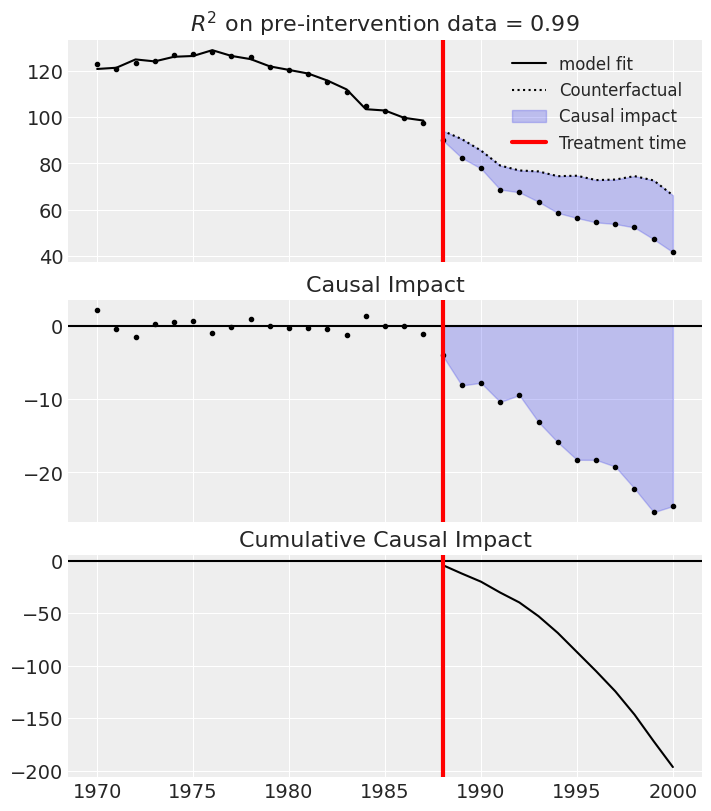

In [52]:
# Ridge回帰を使ってみる
from sklearn.linear_model import Ridge

# 線形回帰モデルでフィッティングした場合
result = cp.SyntheticControl(
    data=processed_df,
    treatment_time=treatment_time,
    formula=f"{treated_state} ~ 0 + {other_states}",
    model=Ridge(positive=True, alpha=100),  # リッジ回帰モデル(正の値のみを予測)
)

result.summary()
fig, ax = result.plot(plot_predictors=True)

### 3.9.2 合成コントロール法の実行手順

問題設定: コロナ禍の緊急事態宣言の発令が商業施設の売り上げに与える影響はどの程度か?

ただし、cp.load_data("sc")を使っているが、データの実態は問題とは関係ないデータ

#### Step 1 ライブラリの準備、データの確認

In [44]:
import causalpy as cp

data_df = cp.load_data("sc")
treatment_time = 70

#### Step 2 DAGの確認

* 結果変数: 商業施設の売上 [百万円/日]
* 処置変数: 緊急事態宣言の発令

![図3.40](images/chap3/image-13.png)

#### Step 3 識別仮定の確認

1. 条件付き独立性
   * 合成対照群を作成することで未観測の交絡因子は存在しないと仮定
   * 共変量の分布は施策前後において変化しないと仮定
2. 正値性: そもそも処置群と対照群に分かれる問題設定なので問題なし
3. SUTVA: 相互作用なしの(処置群兄、対照群内、処置群-対象群間で個体が互いに影響を及ぼさない)仮定を満たすことが重要。緊急事態宣言を受けた店舗がそれぞれ遠方にあるので、その他の店舗に影響しないとする

また、回帰分析で処置群と合成対照群が近似できるかの確認が必要。対照群の加重平均で処置群を近似できない場合SCを使用しないこと。

#### Step 4 因果効果の推定

In [45]:
result = cp.SyntheticControl(
    data_df,
    treatment_time,
    # actualが処置群、a ~ gは対照群. 0は切片の設定
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),  # 重み付けモデル
)

#### Step 5 結果の評価

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a	      0.38
  b	      0.17
  c	      0.44
  d	         0
  e	   5.4e-18
  f	         0
  g	         0


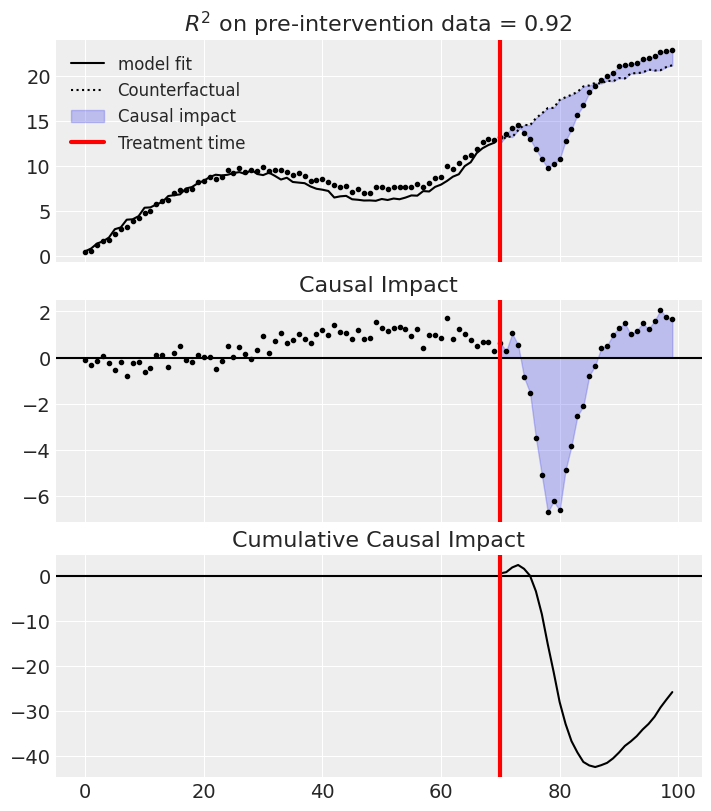

In [47]:
# 重み付けの内訳
result.summary()
# プロット
fig, ax = result.plot(plot_predictors=True)

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a	      0.32
  b	     0.058
  c	      0.29
  d	     0.056
  e	    0.0042
  f	      0.23
  g	     0.038


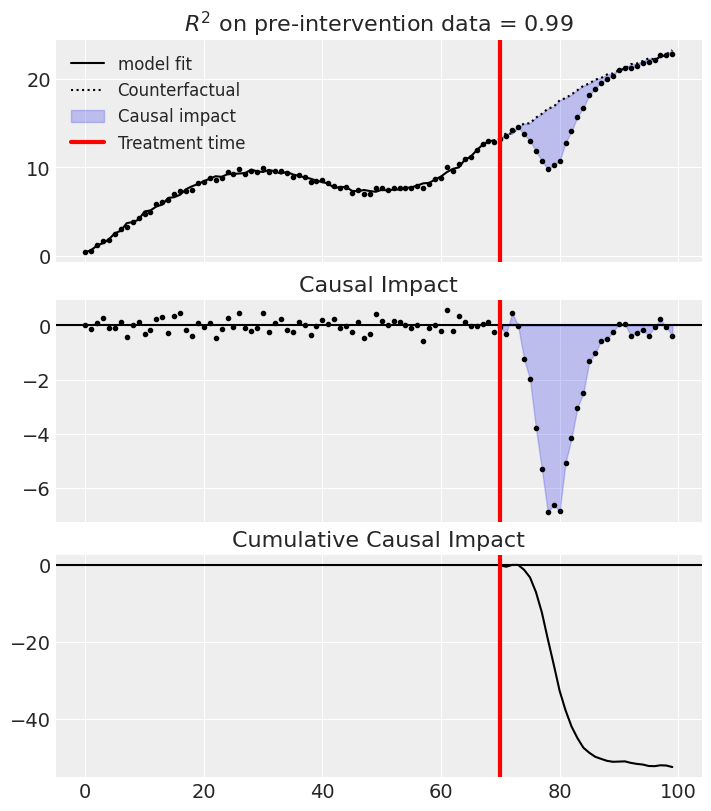

In [48]:
from sklearn.linear_model import LinearRegression

# 線形回帰モデルでフィッティングした場合
result = cp.SyntheticControl(
    data_df,
    treatment_time,
    # actualが処置群、a ~ gは対照群. 0は切片の設定
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=LinearRegression(positive=True),  # リッジ回帰
)

result.summary()
fig, ax = result.plot(plot_predictors=True)

# このデータではこちらのほうがフィットしている

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a	      0.34
  b	     0.053
  c	      0.18
  d	     0.032
  e	     0.025
  f	      0.17
  g	      0.11


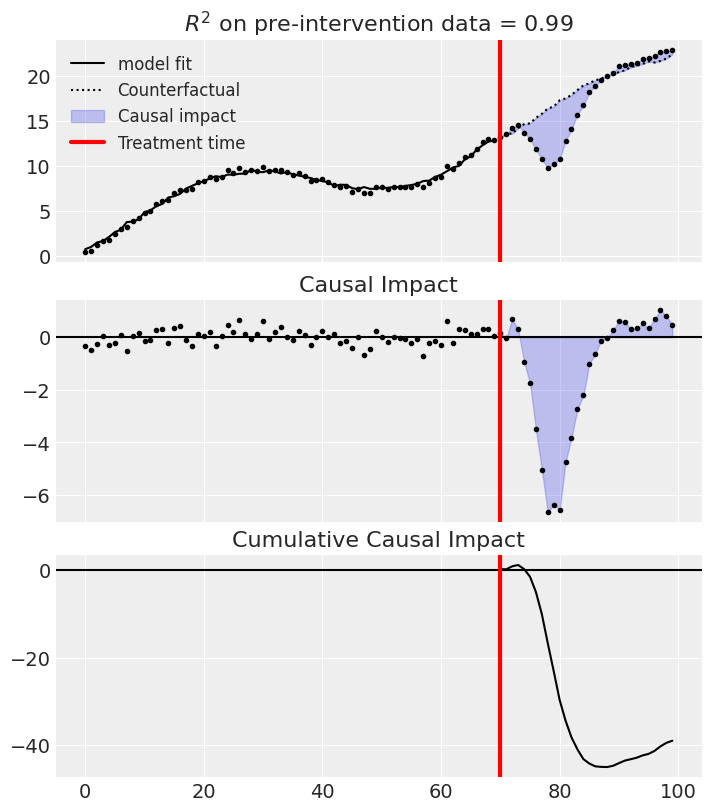

In [49]:
# Ridge回帰を使ってみる
from sklearn.linear_model import Ridge

# 線形回帰モデルでフィッティングした場合
result = cp.SyntheticControl(
    data_df,
    treatment_time,
    # actualが処置群、a ~ gは対照群. 0は切片の設定
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=Ridge(positive=True, alpha=100),  # リッジ回帰
)

result.summary()
fig, ax = result.plot(plot_predictors=True)

モデルの選択によってフィッティングの状態、効果推定の値がかなり変わる。
今回はおおよそ最大で-40~50[百万円]の影響があったというところ

### 3.9.3 合成コントロール法の課題

1. 共変量が施策前後で大きく変化する場合は推定できない(共変量の分布が施策前後で前後しないという仮定をおいている)
2. サンプル数が多く、時系列が短い場合、対照群の合成がうまくできない

発展系の手法
* Robust Synthetic Control: ノイズや欠損データに強い
* Synthetic DID: SCとDiDの併用
* Generalized Synthetic Control: 一般化した方法